# **Bayesian Regression - Closed Form Model**

Using the historical data we find the best lap time set per driver per year.

Model 1 - Bayesian regression on best lap times per driver using 2017/18/19 data, the output posterior of this is the parameters of the model given the data. This output will be the prior for the new model - this can be saved  to a pickle file so it does not have to be re-run before real time updates (note that the closed form model runs fast anyway but this may be useful for the sampling model).

Model 2 - Bayesian regression on incoming lap times per driver sequentially to update the parameters (weights and biases), at each update I calculate the predicted cut-off for 2020 per driver, rank them and take the 16th as the cutoff prediction for Q1 and the 11th for Q2 (this runs in live time and has standard deviation as per requested). Note that for drivers who have no historical data a non-informative prior is used instead of the posterior from model 1. Note that it only updates if a faster lap comes in and therefore will automatically avoid updating on slow laps.

The feature value here is only the value 2020 in both models as there was not enough data to incorporate other features, also there seems to be a strong time dependency.

Bayesian Regression was coded from scratch using the MML (Matematics for Machine Learning) book by Marc Deisenroth, I have tried to use the book notation where I can so that it is clear and labelled where certain book equatins are used.

Make sure to specify if you want Q1 or Q2 in the cell directly below.
Make sure to specify if you want to include historical data (i.e.to run Model 1) - if not Model 2 will take P3 data parameters as the prior.

In [1]:
Session = 'Q2' # enter session that we are interested in: 'Q1' or 'Q2'
Historicals = False # enter false if you do not want to run with historical data i.e. bypass model 1 and use practice data as model 2 prior

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from IPython.display import display

import scipy as sp
import itertools

from scipy.stats import norm, multivariate_normal
#from scipy.optimize import minimize

import pickle
import copy

In [3]:
## Optional: Function can save the prior dictionary created as a pickle file, so that Model 1 does not have to be run again ##

def savePickle(prior, name):

    with open(name + '.pickle', 'wb') as handle:
        pickle.dump(prior, handle, protocol = pickle.HIGHEST_PROTOCOL)

In [4]:
## Function will open pickle file ##

def openPickle(name):
  
    filename = name + '.pickle'

    with open(filename, 'rb') as file:
        prior = pickle.load(file)

    return prior

Data Processing

In [5]:
## Read data into a Pandas DataFrame from a CSV file ##

def read_data(filename):
    
    df = pd.read_csv(filename)
    
    # select required columns
    d = df[['Season', 'Time of Day', 'Session', 'Driver Short Name', 'Full Lap', 'Team']].copy()
    
    ''' some sectors have missing values (probably where a car has been taken off, 
    convert the white space to NaN objects and drop them'''
    
    d.replace(' ', np.nan, inplace = True) 
                                              
    data = d.dropna()
    
    return data

In [6]:
## Remove Slow Laps ##

def drop_slow_laps(data):
    
    threshold = np.min(data['Full Lap']) + 3 # would not expect drivers to have best laps > 2 seconds of the min but use 3 for redundancy
    
    clean_data = data[data['Full Lap'] <= threshold]
    
    return clean_data

In [7]:
## Read in all relevant files - excluding sessions where there was rain or a red flag ##

# read data
data_20 = read_data('07_19Bud_Qu_2020.csv')
data_19 = read_data('08_04Bud_Qu_2019.csv')
data_18 = pd.DataFrame(columns = ['Season', 'Time of Day', 'Session', 'Driver Short Name', 'Full Lap']) # RAIN Session
data_17 = read_data('07_30Bud_Qu_2017.csv')
practice_20 = pd.read_csv('07_19Bud_P3_2020.csv')

# split data into Q1 and Q2 per year
data_20_Q1 = drop_slow_laps(data_20[data_20['Session'] == 'Q1'])
data_20_Q2 = drop_slow_laps(data_20[data_20['Session'] == 'Q2'])

data_19_Q1 = drop_slow_laps(data_19[data_19['Session'] == 'Q1'])
data_19_Q2 = drop_slow_laps(data_19[data_19['Session'] == 'Q2'])

data_18_Q1 = drop_slow_laps(data_18[data_18['Session'] == 'Q1'])
data_18_Q2 = drop_slow_laps(data_18[data_18['Session'] == 'Q2'])

data_17_Q1 = drop_slow_laps(data_17[data_17['Session'] == 'Q1'])
data_17_Q2 = drop_slow_laps(data_17[data_17['Session'] == 'Q2'])


# order 2020 data by time (for real time updates)
data_20_Q1 = data_20_Q1.sort_values(['Time of Day'])
data_20_Q2 = data_20_Q2.sort_values(['Time of Day'])

# list of all historical dataframes for Q1 and Q2
hist_data_Q1 = [data_19_Q1, data_18_Q1, data_17_Q1]
hist_data_Q2 = [data_19_Q2, data_18_Q2, data_17_Q2]

In [8]:
## Converts time string into a time delta ##

def time_delta(time):
    
    time_format = '%H:%M:%S.%f'
    
    dt = datetime.strptime(time[:-4], time_format).time()  # convert to milliseconds and make datetime object
    
    t = timedelta(hours = dt.hour, minutes = dt.minute, seconds = dt.second, microseconds = dt.microsecond) # make timedelta
    
    return t

In [9]:
## Find the exact start time of each session ##

timing = pd.read_csv('07_19Bud_TimeQu_2020.csv')

time_format = '%H:%M:%S.%f'

Q1_start_time = time_delta(timing.iloc[0, 1])
Q2_start_time = time_delta(timing.iloc[1, 1])


print(f'Q1 Start Time is: {Q1_start_time}, Q2 Start Time is: {Q2_start_time}')

Q1 Start Time is: 14:59:59.781000, Q2 Start Time is: 15:24:59.752000


In [10]:
display(data_20_Q1) # view data

,Season,Time of Day,Session,Driver Short Name,Full Lap,Team
25,2020,15:02:47.6520000,Q1,VER,75.873,Red Bull
0,2020,15:02:54.5930000,Q1,HAM,75.265,Mercedes AMG
6,2020,15:03:02.4190000,Q1,BOT,75.273,Mercedes AMG
19,2020,15:03:08.2380000,Q1,ALB,76.367,Red Bull
61,2020,15:03:12.0210000,Q1,STR,75.546,Racing Point
...,...,...,...,...,...,...
44,2020,15:18:36.4310000,Q1,RIC,75.743,Renault
5,2020,15:18:40.3900000,Q1,HAM,74.802,Mercedes AMG
18,2020,15:18:49.6240000,Q1,LEC,75.688,Ferrari
9,2020,15:18:54.8800000,Q1,BOT,75.369,Mercedes AMG


In [11]:
## Names of drivers that made it into each qualifying session ##

names_2020_Q1 = np.unique(data_20_Q1['Driver Short Name']) # finds the drivers that raced in 2020 Q1
assert len(names_2020_Q1) == 20

names_2020_Q2 = np.unique(data_20_Q2['Driver Short Name']) # finds the drivers that raced in 2020 Q1
assert len(names_2020_Q2) == 15

In [12]:
## Fastest lap time per driver ##

def best_lap(data, name): # driver name is a string i.e 'HAM'
    
    if np.sum(data['Driver Short Name'] == name) > 0: # if there is data for the driver
    
        df = data[data['Driver Short Name'] == name]
        min_idx = np.where(df['Full Lap'] == np.min(df['Full Lap']))[0]
        fastest = df.iloc[min_idx, :]

        return fastest

    else: # if there is not data for the driver
        
        return [0, 0, 0, 0, 0] # list of 5 - bigger than it can possibly be so shows where there is missing data, 
                               # can use this to filter it out later

In [13]:
## Store hisotircal best lap for all drivers for Q1 and Q2 ##

lap_dict_Q1 = {}

for name in names_2020_Q1:
    laps = pd.DataFrame()

    for data in hist_data_Q1:
        lap = best_lap(data, name)

        if len(lap) < 5: # for drivers without historical data, fills in blank lap
            laps = laps.append(lap)

    lap_dict_Q1[name] = laps


    
lap_dict_Q2 = {}

for name in names_2020_Q2:
    laps = pd.DataFrame()
    
    for data in hist_data_Q2:
        lap = best_lap(data, name)

        if len(lap) < 5:
            laps = laps.append(lap)
        
    lap_dict_Q2[name] = laps

In [14]:
lap_dict_Q1['HAM']

,Season,Time of Day,Session,Driver Short Name,Full Lap,Team
6,2019,15:18:45.7210000,Q1,HAM,75.965,Mercedes AMG
2,2017,14:05:58.4960000,Q1,HAM,77.354,Mercedes AMG


In [15]:
lap_dict_Q2['HAM']

,Season,Time of Day,Session,Driver Short Name,Full Lap,Team
68,2019,15:28:16.6460000,Q2,HAM,75.445,Mercedes AMG
82,2017,14:39:05.4700000,Q2,HAM,76.601,Mercedes AMG


In [16]:
## Fastest lap time per driver - modified for practice session where drivers are missing ##

def fast_lap(data, name): # driver name is a string i.e 'HAM'
    
    if name in np.unique(practice_20['Driver Short Name']):
    
        df = data[data['Driver Short Name'] == name]
        min_idx = np.where(df['Full Lap'] == np.min(df['Full Lap']))[0]
        fastest = df.iloc[min_idx, :]['Full Lap'].item()

    else: # if there is not data for the driver
        fastest = 0
    
    return fastest

In [17]:
## Find best practice lap and estimate sd on it per Driver ##

p3_best_lap_Q1_drivers = {} # best p3 lap set for all drivers in Q1

for name in names_2020_Q1:
    
    lap = fast_lap(practice_20, name)
    weight_mean = lap/2020 # model parameters consist of weights and biases, model requires mean weights sd weights, mean biases and sd biases
    lap_sd = lap * 0.02 # standard deviation is initially set to 2% of lap time in the prior for model 1 (non-informative)
    weight_sd = lap_sd/2020
    p3_best_lap_Q1_drivers[name] = [lap, weight_mean, lap_sd, weight_sd]
    
    
p3_best_lap_Q2_drivers = {} # best p3 lap set for all drivers in Q2

for name in names_2020_Q2:
    
    lap = fast_lap(practice_20, name)
    weight_mean = lap/2020
    lap_sd = lap * 0.02
    weight_sd = lap_sd/2020
    p3_best_lap_Q2_drivers[name] = [lap, weight_mean, lap_sd, weight_sd]
    

In [18]:
## If a driver has no practice data take the median of the other driver values ##

q1_laps = []
q1_weight_means = []
q1_lap_sds = []
q1_weight_sds = []

for key, value in p3_best_lap_Q1_drivers.items():
    q1_laps.append(value[0])
    q1_weight_means.append(value[1])
    q1_lap_sds.append(value[2])
    q1_weight_sds.append(value[3])

q1_laps_med = np.median(q1_laps)   
q1_weight_means_med = np.median(q1_weight_means)
q1_lap_sds_med = np.median(q1_lap_sds)
q1_weight_sds = np.median(q1_weight_sds)

for key, value in p3_best_lap_Q1_drivers.items():
    
    if value[0] == 0:
        p3_best_lap_Q1_drivers[key] = [q1_laps_med, q1_weight_means_med , q1_lap_sds_med, q1_weight_sds]
        

q2_laps = []
q2_weight_means = []
q2_lap_sds = []
q2_weight_sds = []

for key, value in p3_best_lap_Q2_drivers.items():
    q2_laps.append(value[0])
    q2_weight_means.append(value[1])
    q2_lap_sds.append(value[2])
    q2_weight_sds.append(value[3])

q2_laps_med = np.median(q2_laps)   
q2_weight_means_med = np.median(q2_weight_means)
q2_lap_sds_med = np.median(q2_lap_sds)
q2_weight_sds = np.median(q2_weight_sds)

for key, value in p3_best_lap_Q2_drivers.items():
    
    if value[0] == 0:
        p3_best_lap_Q2_drivers[key] = [q2_laps_med, q2_weight_means_med , q2_lap_sds_med, q2_weight_sds]

Model Components

In [19]:
## Model 1 to get the posterior on parameters given historical data = prior for model 2 ##

def fitBR(inputs, observed, initial_params = None):
    
    if initial_params != None:
        initial_slope, initial_sigma, initial_intercept = initial_params # initial params is a list of tuples (mean, sd)
  
    else: # set non-informative priors for the parameters that have no historical data - this will not ever be called unless we are not going to use P3 priors (kept for redundancy)
        initial_slope = (0, 1) 
        initial_intercept = (0, 1)
        initial_sigma = 1 # non informative sigma term for likelihood term (eq 9.35 MML)
    
    prior_m_w = initial_slope[0] # prior weights/slope
    prior_m_b = initial_intercept[0] # prior biases/intercept
    
    prior_s_w = initial_slope[1] # prior weights/slope sd
    prior_s_b = initial_intercept[1] # prior biases/intercept sd
    
    m_0 = np.hstack([prior_m_w, prior_m_b]).reshape(-1, 1) # prior mean

    S_0 = np.diag([prior_s_w**2, prior_s_b**2]) # prior covariance matrix - set it to a diagonal matrix so that the variables are independent i.e weights and biases have no covariance

    S_0_inv = np.linalg.inv(S_0) # prior covariance matrix inverse

    sigma_squared = initial_sigma ** 2 # likelihood variance

    phi = np.vstack([inputs, np.ones(len(inputs))]).T # features matrix NxD by MML convention
    y = observed.reshape(-1, 1).astype('float64') # labels vector Nx1 by MML convention

    S_N = np.linalg.inv(S_0_inv + (1/sigma_squared) * (phi.T @ phi)) # posterior covariance (eq 9.43b MML)
    m_N = S_N @ (S_0_inv @ m_0 + (1/sigma_squared) * (phi.T @ y)) # posterior mean (eq 9.43c MML)
    
    return m_N, S_N

In [20]:
## Predicts a series of gaussians for each input point, it returns the mean and sd of each prediction (eq 9.57c MML) ##

def pred(inputs, mu_post, cov_post, sigma_lik):
    
    '''
    Dimensions of inputs (MML book convention): 
    
    inputs: N
    mu_post: Dx1 (posterior mean)
    cov_post: DxD (posterior covariance)
    sigma_lik: scalar
    '''
    phi = np.vstack([inputs, np.ones(len(inputs))]).T
    
    mu = phi @ mu_post.reshape(-1, 1) # Nx1
    var = phi @ cov_post @ phi.T + (sigma_lik ** 2) # Nx1 - variance not covariance
    sd = np.sqrt(np.abs(var))
    
    return mu, sd

In [21]:
## Model 2 to update the posterior as new data gets fed in ##

def updateBR(inputs, observed, initial_params): # initial params should be a list of [m0, S_0, sigma]
    
    m_0 = initial_params[0]
    S_0 = initial_params[1]
    S_0_inv = np.linalg.inv(S_0)
    
    sigma_squared = initial_params[2] ** 2

    phi = np.vstack([inputs, np.ones(len(inputs))]).T # features matrix NxD 
    y = observed.reshape(-1, 1).astype('float64') # labels vector Nx1

    S_N = np.linalg.inv(S_0_inv + (1/sigma_squared) * (phi.T @ phi))  # posterior covariance 
    m_N = S_N @ (S_0_inv @ m_0 + (1/sigma_squared) * (phi.T @ y))  # posterior mean
    
    return m_N, S_N

In [22]:
## Closed form update for sigma likelihood term (eq 9.22 MML (maximum likelihood estimate of the noise variance)) ##

def fit_sigma_lik(init, inputs, observed, prior_mean, prior_cov):
    
    if len(inputs) > 1: # if there is enough historical data for drivers (requires 2 points)
        phi = np.vstack([inputs, np.ones(len(inputs))]).T
        preds = phi @ prior_mean
        sigma_sq = np.mean((observed - preds.reshape(-1))**2)
        sigma = np.sqrt(sigma_sq)
        
        return sigma
    
    else:
        return init

Model 1

In [23]:
## Find the priors for all drivers using Model 1 and stores them ##

if Session == 'Q1':
    historical_data = lap_dict_Q1 
    names_2020 = names_2020_Q1
    sigma_list = 1 * np.ones(len(names_2020)) # sigma original value for each driver - set arbitrarily to 1 for each driver
    p3_best_lap = p3_best_lap_Q1_drivers

elif Session == 'Q2':
    historical_data = lap_dict_Q2
    names_2020 = names_2020_Q2
    sigma_list = 1 * np.ones(len(names_2020))
    p3_best_lap = p3_best_lap_Q2_drivers
    

driver_prior = {}
 
for idx, driver in enumerate(names_2020):
    
    #print(f'Current Driver: {driver}')
    driver_data = historical_data[driver]
    
    # set prior weight to practice session and prior bias is non-informative
    
    prior_m_w = p3_best_lap[driver][1] # practice session mean / 2020
    prior_s_w = p3_best_lap[driver][3] # practice session sd / 2020
    
    prior_m_b = 0
    prior_s_b = 1
    
    m_0 = np.hstack([prior_m_w, prior_m_b]).reshape(-1, 1) # prior mean

    S_0 = np.diag([prior_s_w**2, prior_s_b**2]) # prior covariance matrix
    
    if Historicals == True: # if we want to include historical data

        if len(driver_data) > 0: # if there is historical data for the driver

            driver_data = driver_data.loc[:, ['Season', 'Full Lap']]
            inputs = np.array(driver_data['Season'].astype('float64')) # features - the season (2020 in this case)
            observed = np.array(driver_data['Full Lap']) # labels - full lap time (best lap per year from pre-processing above)

            sigma_lik = sigma_list[idx] # likelihood sigma term starting point (non-infomative)
            driver_posterior = fitBR(inputs, observed, [(prior_m_w, prior_s_w), sigma_lik, (prior_m_b, prior_s_b)]) # fit to historicals using Model 1

            new_sigma_lik = fit_sigma_lik(sigma_lik, inputs, observed, driver_posterior[0], driver_posterior[1]) # update the likelihood sigma term
            driver_prior[driver] = [driver_posterior[0], driver_posterior[1], sigma_lik, new_sigma_lik] # update prior dictionary

        else: # if there is no historical data for the driver then keep prior as practice session weight and estimated bias
            sigma_lik = sigma_list[idx]
            driver_prior[driver] = [m_0, S_0, sigma_lik, sigma_lik]
    
    else:
        sigma_lik = sigma_list[idx]
        driver_prior[driver] = [m_0, S_0, sigma_lik, sigma_lik] # note that without historical data we cannot use MLE to find sigma in likelihood

In [24]:
## Store driver names as an index and keep dictionary both ways to later identify drivers ##

name_to_idx = {} 
idx_to_name = {}

idx = 0

for name in names_2020:
    name_to_idx[name] = idx
    idx_to_name[idx] = name
    idx += 1

In [25]:
## Initialize everything ##

current_predictions = []
current_predictions_sd = []
current_predictions_conservative = [] # will store mean - sd for each driver

inputs = [2020]

for name in names_2020:
    
    if len(driver_prior[name]) > 0:
        
        mean_pred, sd_pred = pred(inputs, driver_prior[name][0], driver_prior[name][1], driver_prior[name][2]) # change to 3 for sigma updates
        current_predictions.append(mean_pred.item())
        current_predictions_sd.append(sd_pred.item())
        current_predictions_conservative.append(mean_pred.item() - sd_pred.item())
        
        
    else:
        
        current_predictions.append(np.inf) # set to a very large value if there is no historical data - this is so it can be identified
        current_predictions_sd.append(1) # set sd to 1
        current_predictions_conservative.append(np.inf)

current_fastest = np.array([np.inf] * len(names_2020)) # set current fastest to be something really big so that the first incoming laps can update the model per driver

i = np.argsort(current_predictions)[-5] # 16th position for Q1, 11th position for Q2 - slowest 5 will not make it through in both rounds
j = np.argsort(current_predictions_conservative)[-5]

print(f'Initial mean predictions from historical data are: {current_predictions}')
print(f'Initial standard deviation predictions from historical data are: {current_predictions_sd}')
print(f'Initial predicted cut-off is: {current_predictions[i]:.3f}')
print('')
print(f'Initial conservative predictions from historical data are: {current_predictions_conservative}')
print(f'Initial conservative predicted cut-off is: {current_predictions_conservative[j]:.3f}')

Initial mean predictions from historical data are: [75.946, 74.839, 75.817, 75.0, 77.156, 75.145, 75.61, 76.07, 74.962, 75.955, 76.326, 75.909, 75.397, 75.448, 75.715]
Initial standard deviation predictions from historical data are: [2.0753597197594447, 2.059211103408293, 2.0734722075783893, 2.0615528128088303, 2.0931362436305956, 2.0636638316353757, 2.070446531548207, 2.0771754764583563, 2.0609998975254706, 2.0754914622806813, 2.0809284731580755, 2.0748181877938126, 2.067337186721121, 2.0680813043978707, 2.0719808131351023]
Initial predicted cut-off is: 75.946

Initial conservative predictions from historical data are: [73.87064028024055, 72.77978889659171, 73.7435277924216, 72.93844718719117, 75.06286375636941, 73.08133616836461, 73.5395534684518, 73.99282452354164, 72.90100010247453, 73.87950853771932, 74.24507152684191, 73.8341818122062, 73.32966281327889, 73.37991869560213, 73.6430191868649]
Initial conservative predicted cut-off is: 73.871


In [26]:
# if any of the drivers did not have prior historical information and initial prediction got set to np.inf then we will replace it with the mean of the other predictions (this is so that the probability function will work))

current_predictions = np.array(current_predictions)
current_predictions_sd = np.array(current_predictions_sd)
mean_of_means = np.mean(current_predictions[current_predictions != np.inf])
mean_of_sd = np.mean(current_predictions_sd[current_predictions_sd != np.inf])

current_predictions[current_predictions == np.inf] = mean_of_means
current_predictions_sd[current_predictions_sd == np.inf] = mean_of_sd

Probability of being safe helper functions

In [27]:
## Work out list of combinations - global variable ##

if Session == 'Q1':
    n = 19

elif Session == 'Q2':
    n = 14

combinations_list = []

for i in range(5):
    combinations = list(itertools.combinations(np.arange(n), i))
    combinations_list.append(combinations)

In [28]:
## Finds a list of the indexes of the drivers that are not the driver we are calculating the probability for ##

def idx_list(target_name):
  
    names_2020_idx = []

    for name in names_2020: 

        if name != target_name: # to find the indexes of the other drivers not the one we are calculating the probability for

            value = name_to_idx[name]
            names_2020_idx.append(value)

    return names_2020_idx

In [29]:
## Calculate probabilities of drivers being slower than lap set for driver in question, P(driver > lap time) ##

# z transform of params first (scipy does this automatically), find cdf area under curve to the right of the mean

def calculate_prob(target, mean, sd, maximum = 200, minimum = 0, plot = False):

    cdf = norm.sf(x = target, loc = mean, scale = sd) # sf = survival function returns 1 - cdf

    if plot == True: # option to plot the pdf curve with the cdf area highlighted

        fig, ax = plt.subplots()
        x_axis = np.arange(minimum, maximum, 0.001)
        ax.plot(x_axis, norm.pdf(x, loc = mean, scale = sd))
        ax.set_title(f'$N \sim ({mean}, ${sd}^2$)$')
        ax.set_xlabel('x')
        ax.set_ylabel('pdf(x)')
        ax.grid(True)
        px = np.arange(target, maximum, 0.01)
        ax.set_ylim(0, 0.25)
        ax.fill_between(px, norm.pdf(px, loc = 3, scale = 2), alpha = 0.5, color = 'g')
        ax.text(4.5, 0.02, f'cdf = {cdf}', fontsize = 15)
        plt.show()

    else:

        pass

    return cdf

In [30]:
## Function works out the probability of the specified driver being safe when they set a specified target lap ##

''' look at the report for how this works and is derived - I have tried to be thorough in the comments here 
- CSB Aug 2021 '''

def driver_safe(target_name, target_lap):
  
    # assume that current_predictions and combinations_list are both global as they will update with the BR model

    names_2020_idx = idx_list(target_name) # find indexes of the drivers who are not the driver that we want to calculate the probability for

    all_probs = np.array([calculate_prob(target_lap, current_predictions[idx], current_predictions_sd[idx]) for idx in names_2020_idx]) # calculate the probabilty of all other drivers being slower than the lap set for the target driver
    all_probs = 1 - (all_probs) #  1 - p(driver < target_lap) = p(driver > target lap), store all drivers like this and index the ones that should be slower to speed the code up (see prob_safe function)

    log_unsafe = prob_unsafe(all_probs, combinations_list) # log probability of target driver being unsafe
    
    safe = 1 - np.exp(log_unsafe)

    return safe # probability of target driver being safe

In [31]:
## Calculates the probability of driver being unsafe ##

def prob_unsafe(all_probs, combinations_list):

    log_comb = []

    for combinations in combinations_list: # i.e for i in [19C4, 19C3, ....]

        log_comb_probs = [] 

        for combination in combinations: # i.e for i in [(1, 2, 3, 4), (4, 3, 18, 12), ..., (0, 3, 9, 11)]

            combination = list(combination) # convert the combination tuple into a list so that it can be used to index below
            probs = copy.deepcopy(all_probs) # create a copy to be safe
            probs[combination] = 1 - probs[combination] # p(driver > target lap) for those in the combination list i.e those that are slower than the target lap and witll be in lower positions than the target driver
            probs = probs + 1e-30 * (probs < 1e-30) # add on a tiny negligable number to any probabilities that are 0 so they become slightly larger, this stops it crashing when we take log(0)
            log_probs = np.log(probs) # take the log of each probability calculated for that particular combination
            log_comb_probs.append(np.sum(log_probs)) # sum the log probabilities (same as multiplying the non-log probabilities) and append each to the list above

        log_comb_probs = np.array(log_comb_probs) # convert the log_probs to an array so we can use the elementwise operations max and sum
        factor = np.max(log_comb_probs) # before we take the exponent of the log probs its benefical to pull out the largest value as a factor so that we can have the exponent of a reasonably sized number, it gets added on at the end
        log_all_comb_probs = log_comb_probs - factor # take away the factor from all elements of this array 
        log_all_comb_prob = np.log(np.sum(np.exp(log_all_comb_probs))) + factor # take the exponent of log probabilities for each combination, add them and take the log, then add on the factor 

        log_comb.append(log_all_comb_prob) # this is the total log probability for 19CX combinations

    # sum all combinations i.e 19C4 + 19C3 + 19C2 + 19C1 + 19C0, need to use the factor trick again
    log_comb = np.array(log_comb)
    factor = np.max(log_comb)
    log_all_comb = log_comb - factor
    log_all_comb = np.log(np.sum(np.exp(log_all_comb))) + factor # log probability of target driver being unsafe

    return log_all_comb 

In [32]:
## Update all drivers probabilities of being safe in one go ##

def update_safe_probs(probability_of_being_safe, observed):
    
    if Session == 'Q1':
        num = 20
    
    elif Session == 'Q2':
        num = 15
    
    for idx in range(num): 
        probability_of_being_safe[idx] = driver_safe(target_name = idx_to_name[idx], target_lap = observed)

    return probability_of_being_safe

Plot construction

In [33]:
# Plot the posterior predictive dist - this will enable a quick check for individual drivers ##

def norm_curves(mean, sd):

    #cdf = norm.sf(x = target, loc = mean, scale = sd) # sf = survival function returns 1 - cdf

    fig, ax = plt.subplots()
    
    x_axis = np.linspace(mean - 3, mean + 3, 1000)
    ax.plot(x_axis, norm.pdf(x_axis, loc = mean, scale = sd))
    ax.set_title(f'$N \sim ({mean:.3f}, ${sd:.3f}^2$)$')
    ax.set_xlabel('Lap time (s)')
    ax.set_ylabel('pdf(Lap time)')
    ax.grid(True)
    plt.show()

# norm_curves(pred_dictionary['NOR'][0], pred_dictionary['NOR'][1]) # look at individual distribution

In [34]:
## Function creates useful plots - normal curves, boxplots, prediction bar charts and actual laps set/predicted cutoff ##

def plots(predictions, standard_dev, cutoff, names_list, data, label, timer, driver_list, laps_recorded, stage):
    
    plot_time = stage
    save_path = '/Users/chanelbrown/Desktop/Notebooks/Bayesian Regression Models and Data Per Track/Hungary-Budapest-Bud/Plots'
    
    if Historicals == True:
        plot_type = 'p3m1m2'
    else:
        plot_type = 'p3m2'
        
    ## Predictive Lap Time Distribution Normal Curves ##
    
    pred_dictionary = {} # store most recent predictions in a dictionary with the driver name as key

    for i in range(len(names_list)):
        pred_dictionary[idx_to_name[i]] = [predictions[i], standard_dev[i]]

    
    # find which team each driver was racing for in the event and return the colour of the team in a dictionary ##
    team_color = {'Mercedes AMG': 'c', 'Alfa Romeo': 'maroon', 'Ferrari': 'r', 'Red Bull': 'b', 'Williams': 'g',
                   'AlphaTauri': 'darkblue', 'Haas': 'pink', 'Racing Point': 'darkmagenta', 'McLaren': 'darkorange', 'Renault': 'gold'}
    
    teams = {}

    for name in names_list:
        teams[name] = np.unique(data[data['Driver Short Name'] == name]['Team']).item()

    driver_color = {} 

    for key, value in teams.items():
        driver_color[key] = team_color[value]

    
    fig, ax = plt.subplots(figsize = (10, 10))

    # find the corresponding team color for the driver and change line style to distinguish between drivers in the same team
    colors = []
    line_dash = []

    for key, value in driver_color.items():

        if value in colors:
            colors.append(value)
            line_dash.append('dotted')
        else:
            colors.append(value)
            line_dash.append('-')

    ax.set_prop_cycle(color = colors, linestyle = line_dash)

    # make plots
    for key, value in pred_dictionary.items():

        mean = value[0]
        sd = value[1]
        x_axis = np.linspace(mean - 2, mean + 2, 1000) # constrain axis so that even for very large sd it doesnt skew plot
        ax.plot(x_axis, norm.pdf(x_axis, loc = mean, scale = sd), linewidth = 2)

    ax.set_title(f'Predictive Lap Time Distributions per Driver at {label} ({Session})', fontsize = 14)
    ax.tick_params(axis = 'both', labelsize = 12)
    ax.set_xlabel('Lap Time (s)', fontsize = 14)
    ax.set_ylabel('Probability Density', fontsize = 14)
    ax.legend(pred_dictionary.keys())
    ax.grid(True)
    plot_name = f'{Session}_{stage}_norm_{plot_type}'
    plt.savefig(f'{save_path}/{plot_name}.png')
    plt.show()

    df = pd.DataFrame(pred_dictionary, index = ['Mean', 'SD'])
    
    
    
    ## Box Plots ##
    
    driver_data = {}

    for name in names_list:

        mu = pred_dictionary[name][0] # mean - renamed to not overwrite for the other plot mean
        sig = pred_dictionary[name][1] # sd
        generated_data = np.random.normal(mu, sig, 100)
        driver_data[name] = generated_data


    df1 = pd.DataFrame(driver_data)
    
    # Was asked to ensure that boxplots are time ordered so this has been done by the median value
    medians = df1.median(axis = 0)
    medians.sort_values(ascending = False, inplace = True)
    names_in_order = list(medians.index)
    
    colors_in_order = [] # must also make sure that the colours are ordered correctly

    for name in names_in_order:
        col = driver_color[name]
        colors_in_order.append(col)
    
    
    data_store = []

    for name in names_in_order:
        data_entry = df1[name]
        data_store.append(data_entry)

    fig, ax = plt.subplots(figsize = (10, 10))
    
    # custom legend
    team_legend2 = [Line2D([0], [0], linestyle = '', marker = 'o', color = 'c'), 
                   Line2D([0], [0], linestyle = '', marker = 'o', color = 'maroon'), 
                   Line2D([0], [0], linestyle = '', marker = 'o', color = 'r'),
                   Line2D([0], [0], linestyle = '', marker = 'o', color = 'b'),
                   Line2D([0], [0], linestyle = '', marker = 'o', color = 'g'),
                   Line2D([0], [0], linestyle = '', marker = 'o', color = 'darkblue'),
                   Line2D([0], [0], linestyle = '', marker = 'o', color = 'pink'),
                   Line2D([0], [0], linestyle = '', marker = 'o', color = 'darkmagenta'),
                   Line2D([0], [0], linestyle = '', marker = 'o', color = 'darkorange'),
                   Line2D([0], [0], linestyle = '', marker = 'o', color = 'gold')]

    team_name2 = ['Mercedes AMG', 'Alfa Romeo', 'Ferrari', 'Red Bull', 'Williams', 'AlphaTauri', 'Haas', 'Racing Point',
                'McLaren', 'Renault']

    bp = ax.boxplot(data_store, patch_artist = True, vert = 0, showfliers = False) # remove outliers since its generated data anyway

    ax.set_yticklabels(names_in_order)
    ax.set_ylabel('Driver Short Name', fontsize = 14)
    ax.set_xlabel('Lap Time (s)', fontsize = 14)
    ax.set_title(f'Predictive Lap Time Distributions per Driver at {label} ({Session})', fontsize = 14)
    ax.tick_params(axis = 'both', labelsize = 12)
    ax.grid(True)
    ax.legend(team_legend2, team_name2)

    for patch, color in zip(bp['boxes'], colors_in_order):
        patch.set_facecolor(color)

    for median in bp['medians']:
        median.set(color ='k', linewidth = 2)
    
    plot_name = f'{Session}_{stage}_box_{plot_type}'
    plt.savefig(f'{save_path}/{plot_name}.png')
    plt.show()
        
        
    ## Bar Charts ##
    
    fig, ax = plt.subplots(figsize = (10, 10))
    
    # order from fastest to slowest lap time
    pred_array = np.array(predictions)
    sd_array = np.array(standard_dev)
    index = np.argsort(pred_array)
    sorted_predictions = pred_array[index]
    sorted_predictions_sd = sd_array[index]
    sorted_names = names_list[index]
    
    sorted_colors = []

    for name in sorted_names:
        col = driver_color[name]
        sorted_colors.append(col)
    
    # custom legend
    team_legend1 = [Line2D([0], [0], color = 'lime'),
                    Line2D([0], [0], color = 'k'),
                    Line2D([0], [0], linestyle = '', marker = 'o', color = 'c'), 
                    Line2D([0], [0], linestyle = '', marker = 'o', color = 'maroon'), 
                    Line2D([0], [0], linestyle = '', marker = 'o', color = 'r'),
                    Line2D([0], [0], linestyle = '', marker = 'o', color = 'b'),
                    Line2D([0], [0], linestyle = '', marker = 'o', color = 'g'),
                    Line2D([0], [0], linestyle = '', marker = 'o', color = 'darkblue'),
                    Line2D([0], [0], linestyle = '', marker = 'o', color = 'pink'),
                    Line2D([0], [0], linestyle = '', marker = 'o', color = 'darkmagenta'),
                    Line2D([0], [0], linestyle = '', marker = 'o', color = 'darkorange'),
                    Line2D([0], [0], linestyle = '', marker = 'o', color = 'gold')]

    team_name1 = ['Cut-Off', 'Standard Deviation', 'Mercedes AMG', 'Alfa Romeo', 'Ferrari', 'Red Bull', 'Williams', 'AlphaTauri', 'Haas', 'Racing Point',
                'McLaren', 'Renault']
    
    ax.axvline(x = cutoff, label = f'Cut-off Time: {cutoff:.3f}s', color = 'lime')
    ax.barh(sorted_names, sorted_predictions, xerr = sorted_predictions_sd, color = sorted_colors)
    
    ax.set_ylabel('Driver Short Name', fontsize = 14)
    ax.set_xlabel('Lap Time (s)', fontsize = 14)
    upper_limit = np.mean(predictions) + 10
    lower_limit = np.mean(predictions) - 10
    ax.set_xlim(lower_limit, upper_limit)
    ax.set_title(f'Predicted Lap Times with Standard Deviation on the Prediction at {label} ({Session})', fontsize = 14)
    ax.tick_params(axis = 'both', labelsize = 12)
    ax.grid(True)
    plt.legend(team_legend1, team_name1)
    plot_name = f'{Session}_{stage}_bar_{plot_type}'
    plt.savefig(f'{save_path}/{plot_name}.png')
    plt.show()
    
    
    ## Plot of actual laps set against time with cutoff imposed ##
    
    fig, ax = plt.subplots(figsize = (20, 10))
    
    # convert time to strings and shorten the print out
    time = []

    for t in timer:
        str_time = str(t)
        time.append(str_time[:11])
    
    # get the team color for each point
    driver_colors = []

    for name in driver_list:

        col = driver_color[name]
        driver_colors.append(col)


    # custom legend
    team_legend = [Line2D([0], [0], marker = 'x', color = 'lime'),
                   Line2D([0], [0], linestyle = '', marker = 'o', color = 'c'), 
                   Line2D([0], [0], linestyle = '', marker = 'o', color = 'maroon'), 
                   Line2D([0], [0], linestyle = '', marker = 'o', color = 'r'),
                   Line2D([0], [0], linestyle = '', marker = 'o', color = 'b'),
                   Line2D([0], [0], linestyle = '', marker = 'o', color = 'g'),
                   Line2D([0], [0], linestyle = '', marker = 'o', color = 'darkblue'),
                   Line2D([0], [0], linestyle = '', marker = 'o', color = 'pink'),
                   Line2D([0], [0], linestyle = '', marker = 'o', color = 'darkmagenta'),
                   Line2D([0], [0], linestyle = '', marker = 'o', color = 'darkorange'),
                   Line2D([0], [0], linestyle = '', marker = 'o', color = 'gold')]

    team_name = ['Cut-Off', 'Mercedes AMG', 'Alfa Romeo', 'Ferrari', 'Red Bull', 'Williams', 'AlphaTauri', 'Haas', 'Racing Point',
                'McLaren', 'Renault']

    ax.scatter(time, laps_recorded, marker = 'o', color = driver_colors, label = 'Driver Lap Set')
    ax.plot(cutoff_times, marker = 'x', color = 'lime')
    upper_lim = np.median(laps_recorded) + 2
    lower_lim = np.median(laps_recorded) - 2
    ax.set_ylim(lower_lim, upper_lim) # only interested in seeing this range, anything outside of it will be slow laps which the cutoff code ignores anyway
    ax.set_xticks(time)
    ax.set_xticklabels(time, rotation = 90)
    ax.tick_params(axis = 'x', labelsize = 11)
    ax.tick_params(axis = 'y', labelsize = 12)
    ax.set_xlabel('Time of the Day', fontsize = 15)
    ax.set_ylabel('Lap Time (s)', fontsize = 15)
    ax.grid(True)
    ax.set_title(f'Actual Lap Times Set and Predicted Cut-Off at {label} ({Session})', fontsize = 20)
    ax.legend(team_legend, team_name)
    
    for i in range(len(time)):
        plt.annotate(driver_list[i], (time[i], laps_recorded[i] + 0.05), va = 'bottom', ha = 'center')
    
    plot_name = f'{Session}_{stage}_line_{plot_type}'
    plt.savefig(f'{save_path}/{plot_name}.png')
    plt.show()
    
    return df

Model 2

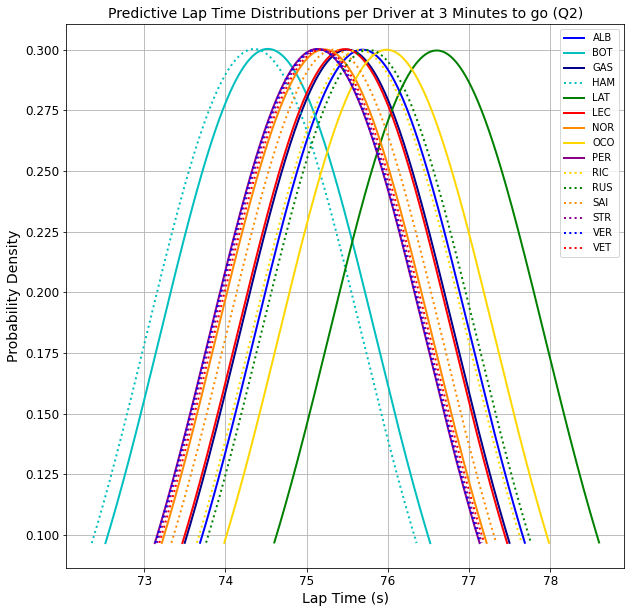

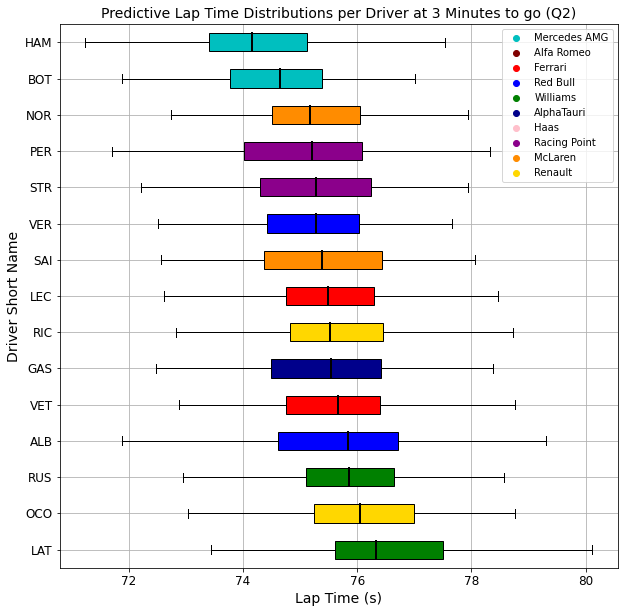

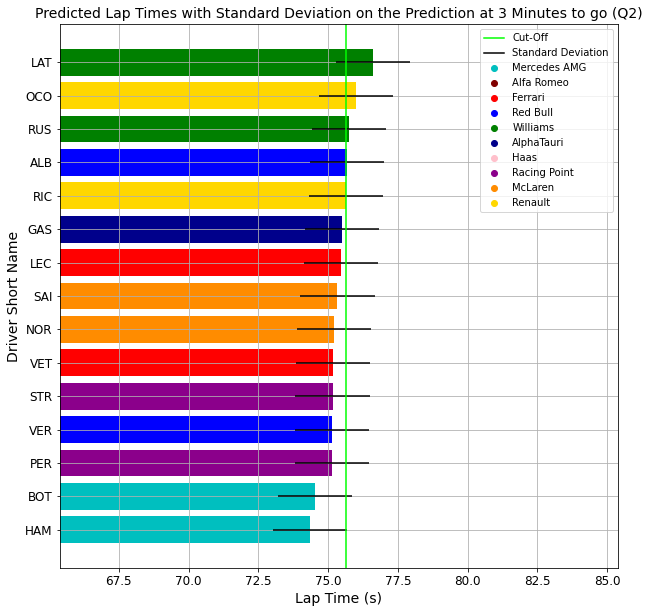

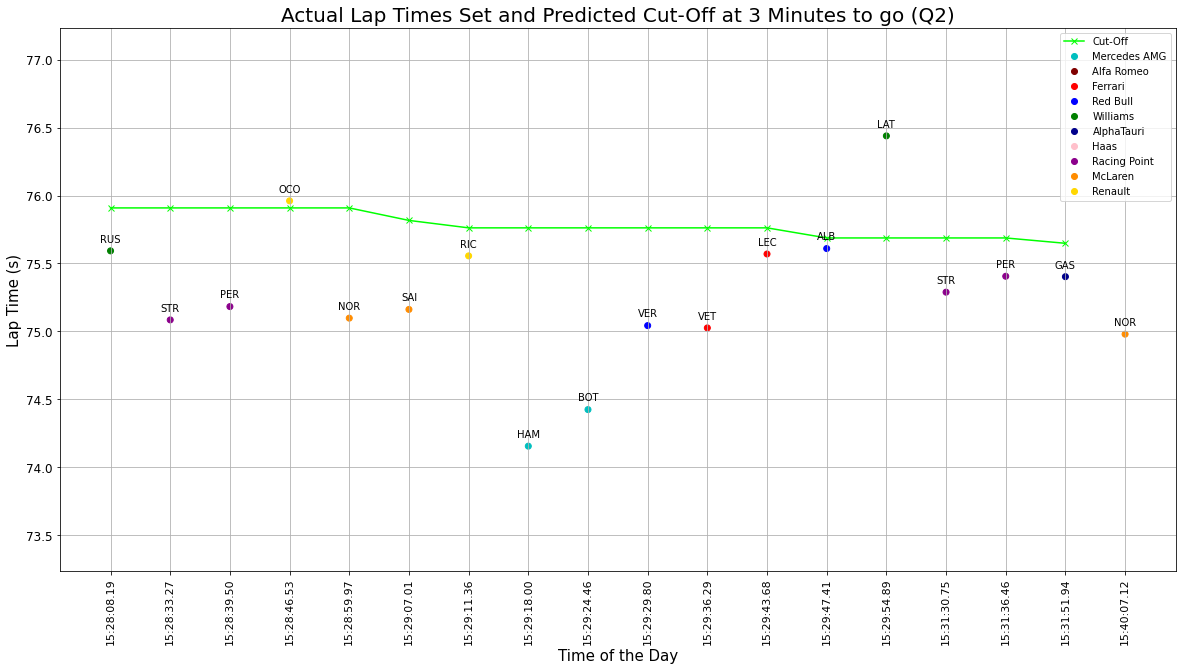

Summary predictions per driver at time 15:31:51.946000:


,ALB,BOT,GAS,HAM,LAT,LEC,NOR,OCO,PER,RIC,RUS,SAI,STR,VER,VET
Mean,75.688010,74.522633,75.499295,74.354588,76.602653,75.470204,75.217438,75.986263,75.130972,75.648626,75.762274,75.335524,75.158002,75.137693,75.186490
SD,1.329596,1.328221,1.329437,1.328422,1.331072,1.328603,1.329181,1.329749,1.328375,1.329607,1.330063,1.329551,1.328917,1.328980,1.329311



Three minutes to go cut-off prediction is: 75.649s, at time: 15:31:51.946000
Three minutes to go probability of being safe for Hamilton is: 0.9325644005982796
Three minutes to go probability of being safe for Bottas is: 0.930301651869403

Three minutes to go conservative cut-off prediction is: 74.319s, at time: 15:31:51.946000


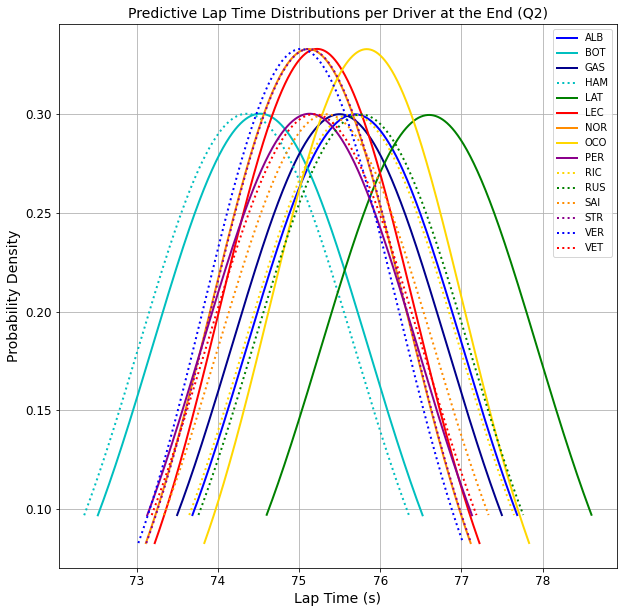

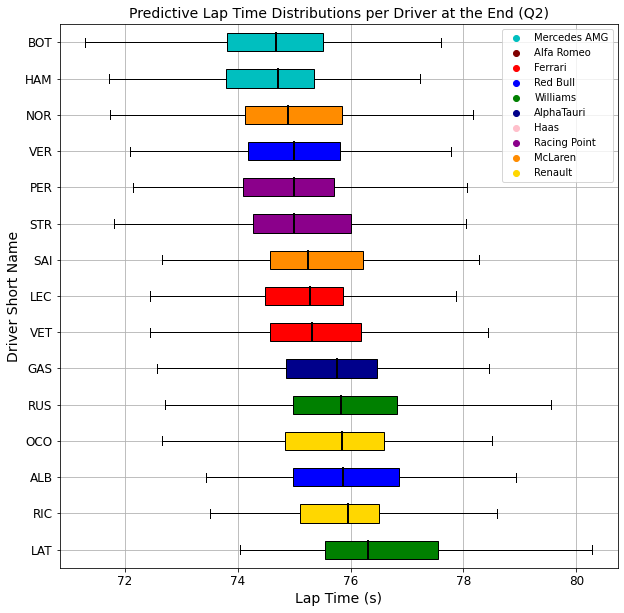

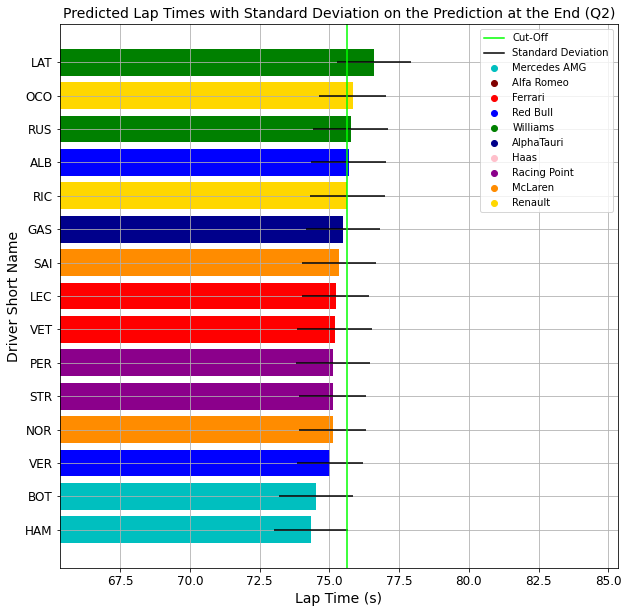

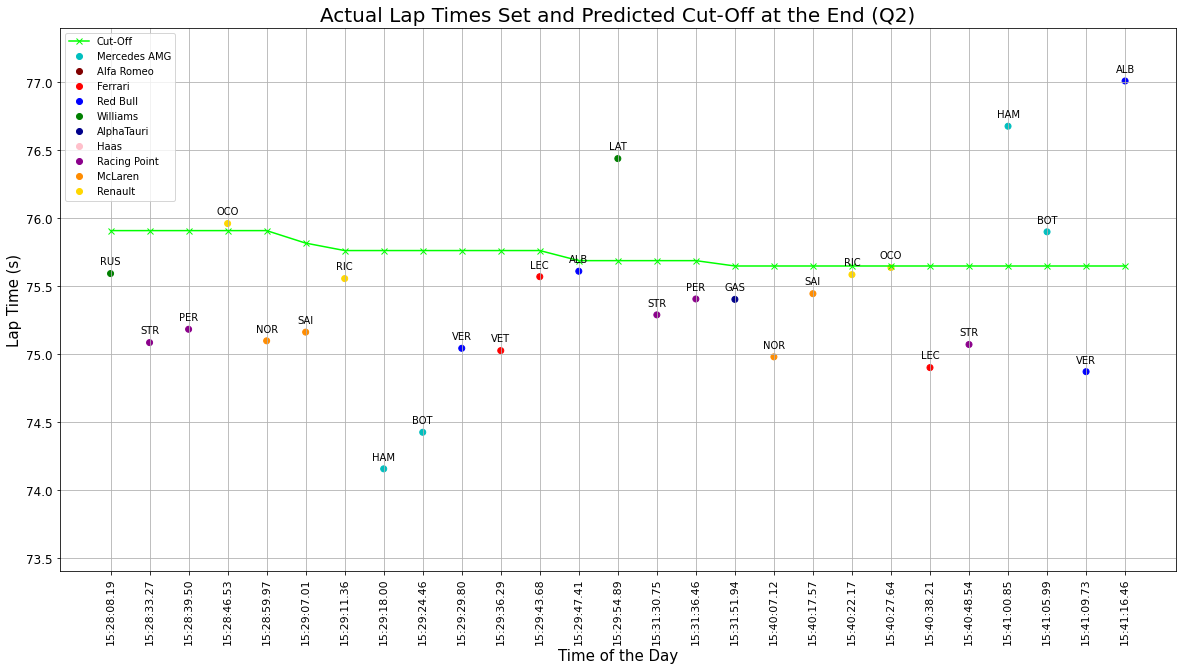



Summary predictions per driver at time 15:41:16.466000:


,ALB,BOT,GAS,HAM,LAT,LEC,NOR,OCO,PER,RIC,RUS,SAI,STR,VER,VET
Mean,75.688010,74.522633,75.499295,74.354588,76.602653,75.223461,75.114394,75.834521,75.130972,75.648626,75.762274,75.335524,75.120264,75.021999,75.186490
SD,1.329596,1.328221,1.329437,1.328422,1.331072,1.197284,1.197489,1.197691,1.328375,1.329607,1.330063,1.329551,1.197395,1.197418,1.329311



Final cut-off prediction is: 75.649s

Final conservative cut-off prediction is: 74.319s


In [35]:
## Update for drivers sequentially and predict cutoff at each update ##

if Session == 'Q1':
    Q_data = data_20_Q1
    len_probs = 20
    tmtg = Q1_start_time + timedelta(minutes = 15) # three mins to go time (18 - 3)
    
elif Session == 'Q2':
    Q_data = data_20_Q2
    len_probs = 15
    tmtg = Q2_start_time + timedelta(minutes = 12) # three mins to go time (15 - 3)
    

cutoff_times = []
conservative_cutoff_times = [] # cutoff when we take the individual predictions as mean - sd for each driver
probability_of_being_safe = [0] * len_probs # set original probabilities of being safe to 0 and store current calculation
driver_update_counter = [0] * len_probs # count the amount of times each driver updates in session
times = [] # store the time stamp of the update
condition_met = 0 # changes to 1 once we have figured out the first lap over the threshold time

predictions_list = [] # contains mean predictions per update per driver i.e [[preds at idx = 0], [preds at idx = 1],...,[preds at idx = n]]
predictions_sd_list = [] # contains sd predictions per update per driver
safe_probs = []
laps_set = [] # contains the order of laps set
driver_order = []


for idx in range(len(Q_data)): # for each new lap recorded
    
    lap = Q_data.iloc[idx, :]
    inputs = [lap['Season']]
    time = time_delta(lap['Time of Day']) # store current time as time delta so that we can find 3 mins to go
    driver = lap['Driver Short Name']
    observed = np.array([lap['Full Lap']])
    
    driver_idx = name_to_idx[driver] # convert driver name to driver index
    
    times.append(time)
    laps_set.append(lap['Full Lap'])
    driver_order.append(driver)

     # this block of code enables us to identify the nearest timestamp to tmtg
    if time > tmtg and condition_met == 0:
        three_mtg = times[-2] # the time closest before the 3 minutes to go threshold - update at which we return everything for 3mtg prediction
        idx_three_mtg = idx - 1 # the index of this time in all of our results lists
        condition_met = 1
        
        HAM_safe_3 = safe_probs[idx_three_mtg][name_to_idx['HAM']] # probability that Hamilton is safe at 3 mins to go
        BOT_safe_3 = safe_probs[idx_three_mtg][name_to_idx['BOT']]
        
        df = plots(predictions = predictions_list[idx_three_mtg], standard_dev = predictions_sd_list[idx_three_mtg], 
                   cutoff = cutoff_times[idx_three_mtg], names_list = names_2020, data = Q_data, label = '3 Minutes to go',
                  timer = times, driver_list = driver_order, laps_recorded = laps_set, stage = '3mtg')
        
        print(f'Summary predictions per driver at time {three_mtg}:')
        display(df)
        print('')
        print(f'Three minutes to go cut-off prediction is: {cutoff_times[idx_three_mtg]:.3f}s, at time: {three_mtg}')
        print(f'Three minutes to go probability of being safe for Hamilton is: {HAM_safe_3}')
        print(f'Three minutes to go probability of being safe for Bottas is: {BOT_safe_3}')
        print('')
        print(f'Three minutes to go conservative cut-off prediction is: {conservative_cutoff_times[idx_three_mtg]:.3f}s, at time: {three_mtg}')
        
    else:
        pass


    if current_fastest[driver_idx] > observed[0]: # if lap set is faster than previous laps set
        current_fastest[driver_idx] = observed[0] # update fastest lap for the driver in question and update model
        driver_update_counter[driver_idx] += 1 # update driver counted
        
        if len(driver_prior[driver]) > 0: # if prior exists, then update weights using informative prior
            prior = driver_prior[driver] # current prior for driver requested
            initial = [prior[0], prior[1], prior[3]] # change to 2 to set sigma to initial default, 3 for MLE update
            new_mu, new_cov = updateBR(inputs, observed, initial) # find posterior for update 
            driver_prior[driver][0] = new_mu # update prior dictionary with posterior from previous update
            driver_prior[driver][1] = new_cov
            
        else:
            new_mu, new_cov = fitBR(inputs, observed) # if no prior exists we have to fit BR to the first data we have for that driver
            sigma_lik = 1  
            new_sigma_lik = fit_sigma_lik(sigma_lik, inputs, observed, new_mu, new_cov) # will also need to update sigma likelihood (note this will only work if you have more than 1 point for that driver)
            driver_prior[driver] = [new_mu, new_cov, sigma_lik, new_sigma_lik]

        # make new prediction for that driver (0 index for mean, 1 for standard deviation, 2 for initial likelihood sigma, 3 for MLE updated sigma)
        prediction = pred(inputs, driver_prior[driver][0], driver_prior[driver][1], driver_prior[driver][3]) # change to 3 to use new sigmas
        current_predictions[driver_idx] = prediction[0].item()
        current_predictions_sd[driver_idx] = prediction[1].item()
        current_predictions_conservative[driver_idx] = prediction[0].item() - prediction[1].item()
        
        probability_of_being_safe = update_safe_probs(probability_of_being_safe, observed) # calculate the probability of each driver being safe with new lap set
        
        #plot_curves(predictions = current_predictions, standard_dev = current_predictions_sd, names_list = names_2020, data = Q_data)  
        
    
    predictions_list.append(list(current_predictions))
    predictions_sd_list.append(list(current_predictions_sd))
    safe_probs.append(list(probability_of_being_safe))
    
    cutoff_idx = np.argsort(current_predictions)[-5] # 16th position for Q1, 11th position for Q2 - slowest 5 will not make it through in both rounds
    cutoff_times.append(current_predictions[cutoff_idx])
    
    conservative_cutoff_idx = np.argsort(current_predictions_conservative)[-5]
    conservative_cutoff_times.append(current_predictions_conservative[conservative_cutoff_idx])

df_final = plots(predictions = predictions_list[-1], standard_dev = predictions_sd_list[-1], 
                 cutoff = cutoff_times[-1], names_list = names_2020, data = Q_data, label = 'the End',
                  timer = times, driver_list = driver_order, laps_recorded = laps_set, stage = 'end')

print('')
print('')
print(f'Summary predictions per driver at time {times[-1]}:')
display(df_final)
print('')    
print(f'Final cut-off prediction is: {cutoff_times[-1]:.3f}s')
print('')
print(f'Final conservative cut-off prediction is: {conservative_cutoff_times[-1]:.3f}s')

Q1 Results

In [38]:
print(cutoff_times) # cutoff time updates - with P3 prior to M1

[77.54840101893244, 77.54840101893244, 77.54840101893244, 77.54840101893244, 77.43342776194817, 77.43342776194817, 77.42349039023615, 77.42349039023615, 77.42349039023615, 77.42349039023615, 77.26052718715977, 77.26052718715977, 77.26052718715977, 77.26052718715977, 77.31495343380726, 77.31495343380726, 77.31495343380726, 77.31495343380726, 77.31495343380726, 77.31495343380726, 77.31495343380726, 77.31495343380726, 77.31495343380726, 77.31495343380726, 77.31495343380726, 77.31495343380726, 77.31495343380726, 77.31495343380726, 77.31495343380726, 77.31495343380726, 77.31495343380726, 77.18997580571468, 77.18997580571468, 77.18997580571468, 77.18997580571468, 77.18997580571468, 77.18997580571468, 77.18997580571468, 77.18997580571468, 77.11639256269268, 77.11639256269268, 77.11639256269268, 77.11639256269268, 77.1051141158552, 77.06027072434158, 77.06027072434158, 77.01589470048322, 77.01589470048322, 77.01589470048322, 77.01589470048322, 77.01589470048322, 77.01589470048322, 77.015894700

In [37]:
print(cutoff_times) # cutoff time updates - with P3 prior to M2 and no M1 (no historicals)

[76.45, 76.45, 76.45, 76.45, 76.45, 76.45, 76.45, 76.58825190189222, 76.58825190189222, 76.58825190189222, 76.58825190189222, 76.58825190189222, 76.656, 76.86, 76.86, 76.86, 76.86, 76.86, 76.86, 76.86, 76.86, 76.86, 76.86, 76.86, 76.86, 76.86, 76.86, 76.86, 76.86, 76.86, 76.86, 76.86, 76.86, 76.86, 76.86, 76.86, 76.86, 76.86, 76.82022802480476, 76.59900548403941, 76.59900548403941, 76.59900548403941, 76.59900548403941, 76.59900548403941, 76.59900548403941, 76.59900548403941, 76.59900548403941, 76.59900548403941, 76.59900548403941, 76.59900548403941, 76.59900548403941, 76.59900548403941, 76.59900548403941, 76.54002805704499, 76.54002805704499, 76.44741824015175, 76.44741824015175, 76.44741824015175, 76.44741824015175, 76.44741824015175, 76.44741824015175]


In [38]:
print(driver_update_counter)

[3, 1, 3, 2, 2, 3, 3, 3, 2, 2, 3, 3, 2, 3, 3, 3, 3, 2, 2, 3]


Q2 Results

In [39]:
print(cutoff_times) # cutoff time updates - with P3 prior to M1

[76.45, 76.45, 76.45, 76.45, 76.45, 76.45, 76.45, 76.58825190189222, 76.58825190189222, 76.58825190189222, 76.58825190189222, 76.58825190189222, 76.656, 76.86, 76.86, 76.86, 76.86, 76.86, 76.86, 76.86, 76.86, 76.86, 76.86, 76.86, 76.86, 76.86, 76.86, 76.86, 76.86, 76.86, 76.86, 76.86, 76.86, 76.86, 76.86, 76.86, 76.86, 76.86, 76.82022802480476, 76.59900548403941, 76.59900548403941, 76.59900548403941, 76.59900548403941, 76.59900548403941, 76.59900548403941, 76.59900548403941, 76.59900548403941, 76.59900548403941, 76.59900548403941, 76.59900548403941, 76.59900548403941, 76.59900548403941, 76.59900548403941, 76.54002805704499, 76.54002805704499, 76.44741824015175, 76.44741824015175, 76.44741824015175, 76.44741824015175, 76.44741824015175, 76.44741824015175]


In [36]:
print(cutoff_times) # cutoff time updates - with P3 prior to M2 and no M1 (no historicals)

[75.909, 75.909, 75.909, 75.909, 75.909, 75.817, 75.76227377100594, 75.76227377100594, 75.76227377100594, 75.76227377100594, 75.76227377100594, 75.76227377100594, 75.68801040106662, 75.68801040106662, 75.68801040106662, 75.68801040106662, 75.64862559126553, 75.64862559126553, 75.64862559126553, 75.64862559126553, 75.64862559126553, 75.64862559126553, 75.64862559126553, 75.64862559126553, 75.64862559126553, 75.64862559126553, 75.64862559126553]


In [40]:
print(driver_update_counter)

[3, 1, 3, 2, 2, 3, 3, 3, 2, 2, 3, 3, 2, 3, 3, 3, 3, 2, 2, 3]


In [38]:
name_to_idx

{'ALB': 0,
 'BOT': 1,
 'GAS': 2,
 'HAM': 3,
 'LAT': 4,
 'LEC': 5,
 'NOR': 6,
 'OCO': 7,
 'PER': 8,
 'RIC': 9,
 'RUS': 10,
 'SAI': 11,
 'STR': 12,
 'VER': 13,
 'VET': 14}